**OTUS - L1**  
Refactor example notebook on Linear Regression  
'House Price Dataset', ML_recap_30_11-163989-36aa70.ipynb)  
Aim: to use pipelines, stacking, feature selection, hyperparameter tuning.  
Dataset description and EDA part are omitted for brevity.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import norm
from yellowbrick.regressor import ResidualsPlot
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import wget
import pickle
import warnings


# from sklearn.metrics import f1_score, make_scorer
# f1 = make_scorer(f1_score,)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

sklearn.set_config(display='diagram')

sns.set_style('darkgrid')
plt.rcParams["figure.figsize"] = [12, 8]
%matplotlib inline

# np.random.seed(17)

warnings.filterwarnings("ignore")

Import dataset

In [2]:
# Data source
url = 'https://docs.google.com/uc?export=download&id=1k21iUIrz0NjfiLE_j-oBQm1bNu3wASX6'
# Read csv
data = pd.read_csv(url, index_col=0)

data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Save dataset

In [3]:
with open("house_prices_df.pkl", "wb") as f:
    pickle.dump(data, f)

Select numerical and categorical columns

In [4]:
# All numerical features
# data.drop(columns=['Alley'], inplace=True)
numerical_columns = data.select_dtypes(
    include=["int", "float"]).columns.to_list()
numerical_features = numerical_columns[:-1]
# All categorical features
categorical_features = data.select_dtypes(
   exclude=["int", "float"]).columns.to_list()
all_features = categorical_features + numerical_features

Transform target variable, remove outliers


In [5]:
# Take log of target variable and
# Set kill_outliers=True to get rid of outliers > 3 sigma (optional)
def transform_data(df, kill_outliers=False):
    target = np.log(df.iloc[:,-1])
    if kill_outliers:
        m = np.mean(target)
        sigma = np.std(target)
        target.drop(target.index[(target < (m - 3*sigma)) | (target > (m + 3*sigma))],inplace=True)
        df = df.loc[target.index]
        df.reset_index(drop=True,inplace=True)
        target.reset_index(drop=True,inplace=True)
    return df, target
data, target = transform_data(data)

**Analize target distribution**

Check target distribution before and after log transformation with boxplot

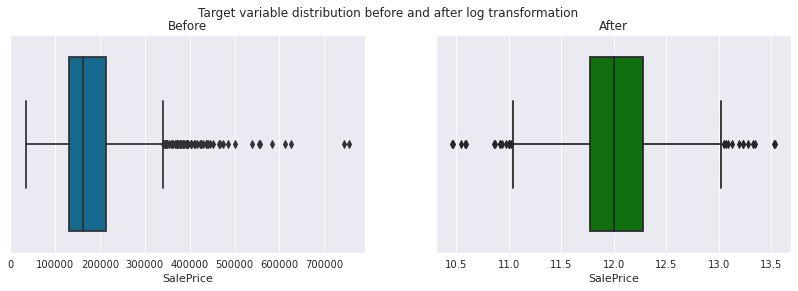

In [6]:
fig, axes = plt.subplots(nrows=1,
                         ncols=2, figsize=(14, 4))
fig.suptitle('Target variable distribution before and after log transformation')
# ax1 = plt.subplot(1,1)
axes[0].set_title('Before')
sns.boxplot(data['SalePrice'], ax=axes[0])
# ax2 = plt.subplot(1,2)
axes[1].set_title('After')
sns.boxplot(target, color='green', ax=axes[1])
plt.show()

Check if target distribution is normal

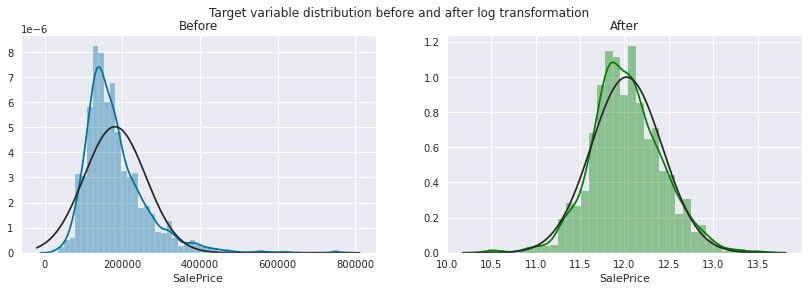

In [7]:
fig, axes = plt.subplots(nrows=1,
                         ncols=2, figsize=(14, 4))
fig.suptitle('Target variable distribution before and after log transformation')
# ax1 = plt.subplot(1,1)
axes[0].set_title('Before')
sns.distplot(data['SalePrice'], fit= norm, ax=axes[0])
# ax2 = plt.subplot(1,2)
axes[1].set_title('After')
sns.distplot(target, fit= norm, color='green', ax=axes[1])
plt.show()
# plt.figure(figsize=(10, 5))
# _ = sns.distplot(data.SalePrice, fit=norm)

**Proceed to ML**

Train-test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data[all_features], target,
                                                    test_size=0.25, random_state=17)

**Build regression pipeline with stacking and hyperparameters search**

Define pipeline elements

In [9]:
# Steps
numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='mean')),
    ("scaler", StandardScaler()),
    ("feature_selector", SelectKBest(score_func=f_classif, k=10))])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))])

data_transformer = ColumnTransformer(transformers=[
    # < -- NB, include target
    ("numerical", numerical_transformer, numerical_features),
    ("categorical", categorical_transformer, categorical_features)])

preprocessor = Pipeline(steps=[("data_transformer", data_transformer)])

estimators = [
    #     ("Linear_Regression", make_pipeline(preprocessor, LinearRegression())),
    ("Linear_Regression", LinearRegression()),
    ("Lasso", Lasso()),
    ("Ridge",  Ridge())]

stacking_regressor = Pipeline(steps=[
    ("Preprocessor", preprocessor),
    ("Stacking_Regressor", StackingRegressor(
        estimators=estimators,
        passthrough=True,
        #     final_estimator=RidgeCV(),
        n_jobs=-1,
        verbose=0))]) #True

Define and execute grid search

In [10]:
# Define grid search
param_grid = {
    # Ranges are chosen after a bit of experimentation
    'Stacking_Regressor__Lasso__alpha': np.linspace(0.2, 0.3, 9),
    'Stacking_Regressor__Ridge__alpha': np.linspace(3.0, 5.0, 9)
}
stacked_grid_search = GridSearchCV(
    stacking_regressor, param_grid, n_jobs=-1, cv=5)  # , scoring=f1)

model = stacked_grid_search.fit(X_train, y_train)

Show the pipeline structure

In [11]:
stacked_grid_search

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Preprocessor',
                                        Pipeline(steps=[('data_transformer',
                                                         ColumnTransformer(transformers=[('numerical',
                                                                                          Pipeline(steps=[('imputer',
                                                                                                           SimpleImputer()),
                                                                                                          ('scaler',
                                                                                                           StandardScaler()),
                                                                                                          ('feature_selector',
                                                                                                           SelectKBest())]),
                                                                                          ['MSSubClass',
                                                                                           'LotFrontage',
                                                                                           'LotArea',
                                                                                           'OverallQual',
                                                                                           'OverallCond',
                                                                                           'YearBuilt',
                                                                                           'YearRemodAdd',
                                                                                           'MasVnr...
                                       ('Stacking_Regressor',
                                        StackingRegressor(estimators=[('Linear_Regression',
                                                                       LinearRegression()),
                                                                      ('Lasso',
                                                                       Lasso()),
                                                                      ('Ridge',
                                                                       Ridge())],
                                                          n_jobs=-1,
                                                          passthrough=True))]),
             n_jobs=-1,
             param_grid={'Stacking_Regressor__Lasso__alpha': array([0.2   , 0.2125, 0.225 , 0.2375, 0.25  , 0.2625, 0.275 , 0.2875,
       0.3   ]),
                         'Stacking_Regressor__Ridge__alpha': array([3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75, 5.  ])})

**Run model and evaluate results**

Fit the model and get the score on train set

In [12]:
# train_score = stacking_regressor.fit(X_train, y_train).score(X_test, y_test)
train_score = model.score(X_train, y_train)
print(f'Model score on training data: {train_score: .4f}')

Model score on training data:  0.8970


Evaluate model on test set

In [13]:
best_score = stacked_grid_search.best_score_
best_params = stacked_grid_search.best_params_
print(f'Best score: {best_score: .4f}\nwith best parameters:')
print(f'         Lasso alpha {best_params["Stacking_Regressor__Lasso__alpha"]: .2f}')
print(f'         Ridge alpha {best_params["Stacking_Regressor__Ridge__alpha"]: .2f}')

model = stacked_grid_search.best_estimator_
# train_score = model.fit(X_train, y_train).score(X_test, y_test)
test_score = model.score(X_test, y_test)
print(f'Model score on test data: {test_score: .4f}')


Best score:  0.8423
with best parameters:
         Lasso alpha  0.20
         Ridge alpha  3.25
Model score on test data:  0.8898


Visualize residuals

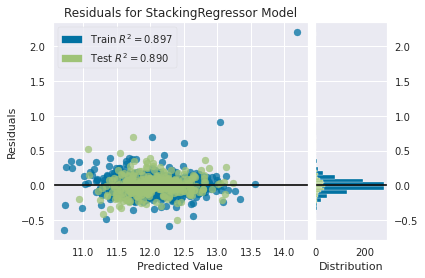

In [14]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
_ = visualizer.show()             # Finalize and render the figure

Evaluate model performance with several metrics  
Use SalePrice instead of its log

In [15]:
# Restore target variable
yhat = np.exp(model.predict(X_test))  # .round(0)
y = np.exp(y_test)

# Metrics
RMSE = mean_squared_error(yhat, y, squared=False)
MAE = mean_absolute_error(yhat, y)
MAPE = mean_absolute_percentage_error(yhat, y)
R2 = r2_score(yhat,y)

print(f"""{RMSE = : 9.1f}
{MAE = : 10.1f}
MAPE = {MAPE*100: 6.2f} %
{R2 = : 8.2f}""")

RMSE =   24298.7
MAE =    16324.5
MAPE =   9.30 %
R2 =     0.90


Save the model

In [16]:
with open("stacked_regression_pipeline.pkl", "wb") as f:
    pickle.dump(stacked_grid_search, f)